In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from category_encoders.target_encoder import TargetEncoder
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy.sparse import hstack, coo_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Чтение данных

In [2]:
times = ['time'+str(i) for i in range(1,11)]

train_df = pd.read_csv('train.csv',
                       index_col='session_id', parse_dates=times)
train_df = train_df.dropna(subset=['target'])

test_df = pd.read_csv('test.csv',
                      index_col='session_id', parse_dates=['time1'])

train_df = train_df.sort_values(by='time1')

train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:36,41475.0,2013-11-15 07:39:36,41476.0,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725.0,2013-11-15 07:42:50,41475.0,2013-11-15 07:42:50,41476.0,2013-11-15 07:42:50,6725.0,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475.0,2013-11-15 07:44:25,41476.0,2013-11-15 07:57:45,6725.0,2013-11-15 07:57:45,41475.0,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476.0,2013-11-15 07:57:47,6725.0,2013-11-15 07:57:49,41475.0,2013-11-15 07:57:49,41476.0,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23.0,2013-11-15 07:52:18,4803.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804.0,2013-11-15 07:52:23,21.0,2013-11-15 07:52:26,23.0,2013-11-15 07:52:26,22.0,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23.0,2013-11-15 07:52:29,22.0,2013-11-15 07:52:37,21.0,2013-11-15 07:52:37,63.0,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784.0,2013-11-15 07:55:56,4804.0,2013-11-15 07:57:50,4804.0,2013-11-15 08:01:18,784.0,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476.0,2013-11-15 07:57:51,6725.0,2013-11-15 07:59:34,41475.0,2013-11-15 07:59:34,41476.0,2013-11-15 07:59:34,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129606,6003,2014-05-03 18:06:13,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
53628,6003,2014-05-03 18:09:26,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
84754,6003,2014-05-03 18:11:21,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [3]:
with open(r"site_dic.pkl", "rb") as input_file:
    site_to_num_dict = pickle.load(input_file)
    
num_to_site_dict = {}
for key in site_to_num_dict:
    num_to_site_dict[site_to_num_dict[key]] = key

## Работа только с сайтами:

Тестируем датасеты:
* только сайты + CountVectorizer/TfIdf + standardScaler/MaxAbsScaler
* сайты + домены + CountVectorizer/TfIdf + standardScaler/MaxAbsScaler

In [4]:
# определим домен для каждого посещенного сайта (.ru, .com)
for i in range(1, 11):
    train_df[f"site{i}_domen"] = train_df[f"site{i}"].apply(lambda x: num_to_site_dict[x].split('.')[-1] 
                                                    if not np.isnan(x) and re.findall('[1-9]', num_to_site_dict[x].split('.')[-1]) == []
                                                           else ('undefined' if np.isnan(x) else 'domen'))
    
for i in range(1, 11):
    test_df[f"site{i}_domen"] = test_df[f"site{i}"].apply(lambda x: num_to_site_dict[x].split('.')[-1] 
                                                    if not np.isnan(x) and re.findall('[1-9]', num_to_site_dict[x].split('.')[-1]) == []
                                                           else ('undefined' if np.isnan(x) else 'domen'))

In [5]:
# заполним пустые значения в сайтах 0
for i in range(1, 11):
    train_df[f"site{i}"] = train_df[f"site{i}"].apply(lambda x: x if not np.isnan(x) else 0).astype(int)
    
for i in range(1, 11):
    test_df[f"site{i}"] = test_df[f"site{i}"].apply(lambda x: x if not np.isnan(x) else 0).astype(int)

## Only sites

In [6]:
X = train_df.drop(times, axis=1)
X = X.drop("target", axis=1)

sites = ['site'+str(i) for i in range(1,11)]
X_sites = X[sites]

y = train_df["target"]

In [7]:
# создадим одну строку с посещенными сайтами
X_sites = X_sites.apply(lambda x: ' '.join([str(x.site1), str(x.site2), str(x.site3), str(x.site4),
                                                        str(x.site5), str(x.site6), str(x.site7), str(x.site8),
                                                        str(x.site9), str(x.site10)]), axis=1)

test = test_df[sites].apply(lambda x: ' '.join([str(x.site1), str(x.site2), str(x.site3), str(x.site4),
                                                        str(x.site5), str(x.site6), str(x.site7), str(x.site8),
                                                        str(x.site9), str(x.site10)]), axis=1)

In [8]:
X_sites_train, X_sites_test, y_train, y_test = train_test_split(X_sites, y, test_size=0.3, random_state=42)

### CountVectorizer

In [9]:
n_ngram = 3

cv = CountVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_train_cv_transform = cv.fit_transform(X_sites_train)
X_sites_test_cv_transform = cv.transform(X_sites_test)

X_sites_cv = cv.fit_transform(X_sites)
test_cv = cv.transform(test)

In [10]:
X_sites_train_cv_transform.shape, X_sites_test_cv_transform.shape, test_cv.shape

((177492, 50000), (76069, 50000), (82797, 50000))

In [11]:
def get_auc_lr_valid(X_train, X_test, y_train, y_test=None, C=1.0, seed=42, 
                     scaled=False, max_abs = False, 
                     for_test=False, out_file='predictions.csv'):
    
    if scaled:
        st = StandardScaler(with_mean=False)
        X_train = st.fit_transform(X_train)
        X_test = st.transform(X_test)
        
    if max_abs:
        min_max = MaxAbsScaler()
        X_train = min_max.fit_transform(X_train)
        X_test = min_max.transform(X_test)
    
    lr = LogisticRegression(C=C, random_state=seed, solver='lbfgs', max_iter=500)
    lr.fit(X_train, y_train)
    
    if for_test:
        preds = lr.predict_proba(X_test)[:, 1]
        predicted_df = pd.DataFrame(preds,
                                index = range(1, preds.shape[0] + 1),
                                columns=["target"])
        predicted_df.to_csv(out_file, index_label="session_id")
        return 'Done!'
    else:
        preds = lr.predict_proba(X_test)[:, 1]
        score = metrics.roc_auc_score(y_test, preds)
        return score

In [12]:
%%time

get_auc_lr_valid(X_sites_train_cv_transform, X_sites_test_cv_transform, y_train, y_test)

CPU times: user 21.9 s, sys: 260 ms, total: 22.1 s
Wall time: 5.78 s


0.9557008987267194

In [13]:
%%time

get_auc_lr_valid(X_sites_train_cv_transform, X_sites_test_cv_transform, y_train, y_test, scaled=True)

CPU times: user 44.2 s, sys: 696 ms, total: 44.9 s
Wall time: 11.6 s


0.7350054704479217

In [14]:
%%time

get_auc_lr_valid(X_sites_train_cv_transform, X_sites_test_cv_transform, y_train, y_test, max_abs=True)

CPU times: user 9.84 s, sys: 228 ms, total: 10.1 s
Wall time: 2.77 s


0.9452130533344256

In [15]:
%%time

get_auc_lr_valid(X_sites_cv, test_cv, y, for_test=True, out_file='predictions.csv')

CPU times: user 38 s, sys: 606 ms, total: 38.6 s
Wall time: 10.1 s


'Done!'

### TfidfVectorizer

In [16]:
n_ngram = 3

tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_train_tfidf_transform = tfidf.fit_transform(X_sites_train)
X_sites_test_tfidf_transform = tfidf.transform(X_sites_test)

X_sites_tfidf = tfidf.fit_transform(X_sites)
test_tfidf = tfidf.transform(test)

In [17]:
%%time

get_auc_lr_valid(X_sites_train_tfidf_transform, X_sites_test_tfidf_transform, y_train, y_test)

CPU times: user 4.8 s, sys: 563 ms, total: 5.36 s
Wall time: 5.92 s


0.9523348849150401

In [18]:
%%time

get_auc_lr_valid(X_sites_tfidf, test_tfidf, y, for_test=True, out_file='predictions.csv')

CPU times: user 12.5 s, sys: 250 ms, total: 12.8 s
Wall time: 3.44 s


'Done!'

In [19]:
n_ngram = 5

tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_train_tfidf_transform = tfidf.fit_transform(X_sites_train)
X_sites_test_tfidf_transform = tfidf.transform(X_sites_test)

X_sites_tfidf = tfidf.fit_transform(X_sites)
test_tfidf = tfidf.transform(test)

In [20]:
%%time

get_auc_lr_valid(X_sites_train_tfidf_transform, X_sites_test_tfidf_transform, y_train, y_test)

CPU times: user 8.18 s, sys: 336 ms, total: 8.52 s
Wall time: 2.6 s


0.9502265233329312

## Sites + domens

In [21]:
domens = [f"site{str(i)}_domen" for i in range(1,11)]
X_domens = X[domens]

# создадим одну строку с посещенными доменами
X_domens = X_domens.apply(lambda x: ' '.join([str(x.site1_domen), str(x.site2_domen),
                                              str(x.site3_domen), str(x.site4_domen),
                                              str(x.site5_domen), str(x.site6_domen),
                                              str(x.site7_domen), str(x.site8_domen),
                                              str(x.site9_domen), str(x.site10_domen)]), axis=1)

test_sites = test_df[sites].apply(lambda x: ' '.join([str(x.site1), str(x.site2), str(x.site3), str(x.site4),
                                                        str(x.site5), str(x.site6), str(x.site7), str(x.site8),
                                                        str(x.site9), str(x.site10)]), axis=1)

test_domens = test_df[domens].apply(lambda x: ' '.join([str(x.site1_domen), str(x.site2_domen),
                                              str(x.site3_domen), str(x.site4_domen),
                                              str(x.site5_domen), str(x.site6_domen),
                                              str(x.site7_domen), str(x.site8_domen),
                                              str(x.site9_domen), str(x.site10_domen)]), axis=1)

In [22]:
n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_train_tfidf_transform = tfidf_domen.fit_transform(X_sites_train)
X_domens_test_tfidf_transform = tfidf_domen.transform(X_sites_test)

X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

In [23]:
%%time

get_auc_lr_valid(hstack((X_sites_train_tfidf_transform, X_domens_train_tfidf_transform)),
                 hstack((X_sites_test_tfidf_transform, X_domens_test_tfidf_transform)),
                 y_train, y_test)

CPU times: user 50.3 s, sys: 1.49 s, total: 51.8 s
Wall time: 15.3 s


0.9568006760475769

In [24]:
%%time

get_auc_lr_valid(hstack((X_sites_tfidf, X_domens_tfidf)),
                 hstack((test_sites_tfidf, test_domens_tfidf)),
                 y, for_test=True, out_file='predictions.csv')

CPU times: user 20.1 s, sys: 425 ms, total: 20.6 s
Wall time: 5.64 s


'Done!'

Оставляем две фичи: сайты и домены.

## Добавим время

* Используем кроссвалидацию по времени

In [25]:
n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = X_for_tscv.tocsr()[train_index,:], X_for_tscv.tocsr()[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid(X_train, X_test, y_train, y_test)
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.8920917939979941
K Fold: 2
roc_auc_score = 0.8085270280511438
K Fold: 3
roc_auc_score = 0.8773565145030908
K Fold: 4
roc_auc_score = 0.8731600145887883
K Fold: 5
roc_auc_score = 0.9259985425446078
Mean roc_auc_score = 0.8754267787371252


### Добавим день недели 

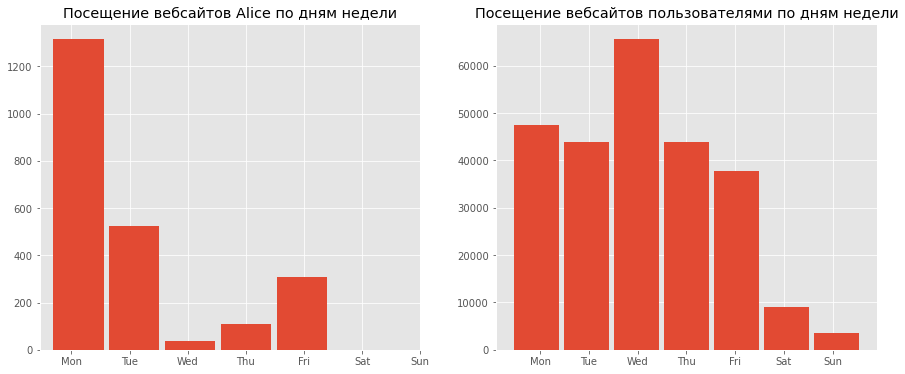

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].hist(train_df[train_df['target'] == 1].apply(lambda x: pd.to_datetime(x.time1).dayofweek, axis=1), 
           bins=5, rwidth=0.9)
ax[1].hist(train_df[train_df['target'] == 0].apply(lambda x: pd.to_datetime(x.time1).dayofweek, axis=1), 
           bins=7, rwidth=0.9)

ax[0].set_xticks(ticks=[i - 0.7 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].set_title('Посещение вебсайтов Alice по дням недели')
ax[1].set_title('Посещение вебсайтов пользователями по дням недели')

plt.show()

In [32]:
tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid(X_train, X_test, y_train, y_test)
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.8221590425743285
K Fold: 2
roc_auc_score = 0.8286426970671343
K Fold: 3
roc_auc_score = 0.920846885401807
K Fold: 4
roc_auc_score = 0.9349916441444193
K Fold: 5
roc_auc_score = 0.9630075158591075
Mean roc_auc_score = 0.8939295570093593


In [33]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))

get_auc_lr_valid(X_train_tmp,
                 X_test_tmp,
                 y, for_test=True, out_file='predictions.csv')

CPU times: user 46.3 s, sys: 1.08 s, total: 47.4 s
Wall time: 25.8 s


'Done!'

### Добавим время года

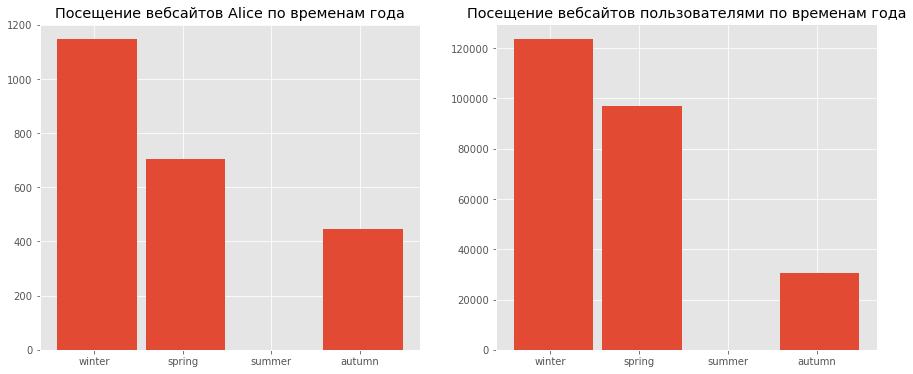

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].hist(train_df[train_df['target'] == 1].apply(lambda x: pd.to_datetime(x.time1).month%12 // 3 + 1, axis=1), 
           bins=4, rwidth=0.9)
ax[1].hist(train_df[train_df['target'] == 0].apply(lambda x: pd.to_datetime(x.time1).month%12 // 3 + 1, axis=1), 
           bins=4, rwidth=0.9)

ax[0].set_xticks(ticks=[i for i in [1.35, 2.1, 2.85, 3.6]])
ax[1].set_xticks(ticks=[i for i in [1.35, 2.1, 2.85, 3.6]])
ax[0].set_xticklabels(labels=['winter', 'spring', 'summer', 'autumn'])
ax[1].set_xticklabels(labels=['winter', 'spring', 'summer', 'autumn'])
ax[0].set_title('Посещение вебсайтов Alice по временам года')
ax[1].set_title('Посещение вебсайтов пользователями по временам года')

plt.show()

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    X_train = hstack((X_train, 
                coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).month%12 // 3 + 1)).T))
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    X_test = hstack((X_test, 
                coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).month%12 // 3 + 1)).T))
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid(X_train, X_test, y_train, y_test)
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.841447702612063
K Fold: 2
roc_auc_score = 0.8311181266036571
K Fold: 3
roc_auc_score = 0.9196105563480741
K Fold: 4
roc_auc_score = 0.937378519194218
K Fold: 5
roc_auc_score = 0.9635477512010332
Mean roc_auc_score = 0.8986205311918092


### Добавим часы

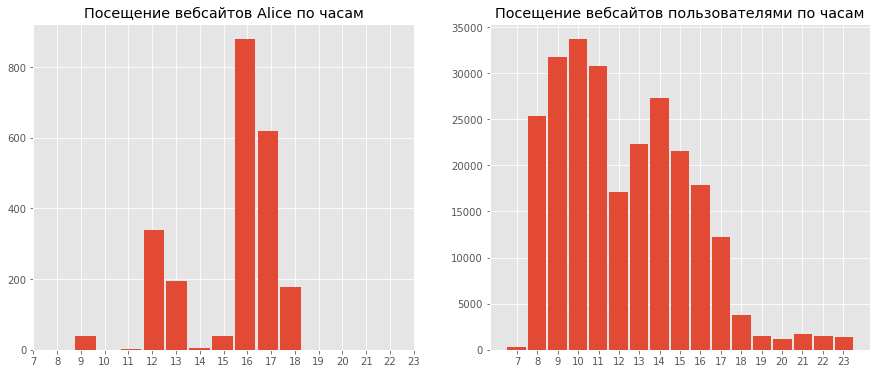

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].hist(train_df[train_df['target'] == 1].apply(lambda x: pd.to_datetime(x.time1).hour, axis=1), 
           bins=10, rwidth=0.9)
ax[1].hist(train_df[train_df['target'] == 0].apply(lambda x: pd.to_datetime(x.time1).hour, axis=1), 
           bins=17, rwidth=0.9)

ax[0].set_xticks(ticks=[i + 0.4 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[1].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[0].set_title('Посещение вебсайтов Alice по часам')
ax[1].set_title('Посещение вебсайтов пользователями по часам')

plt.show()

In [37]:
tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    X_train = hstack((X_train, 
                coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).month%12 // 3 + 1)).T))
    X_train = hstack((X_train, 
                coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).hour)).T))
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    X_test = hstack((X_test, 
                coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).month%12 // 3 + 1)).T))
    X_test = hstack((X_test, 
                coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).hour)).T))
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid(X_train, X_test, y_train, y_test, max_abs=True)
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.8921283617295754
K Fold: 2
roc_auc_score = 0.855908365541806
K Fold: 3
roc_auc_score = 0.9491859248692345
K Fold: 4
roc_auc_score = 0.9495354579456781
K Fold: 5
roc_auc_score = 0.9787493626074776
Mean roc_auc_score = 0.9251014945387543


In [38]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).month%12 // 3 + 1)).T))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).hour)).T))

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).month%12 // 3 + 1)).T))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).hour)).T))

get_auc_lr_valid(X_train_tmp,
                 X_test_tmp,
                 y, 
                 max_abs=True, for_test=True, out_file='predictions.csv')

CPU times: user 55.6 s, sys: 1.7 s, total: 57.3 s
Wall time: 34.4 s


'Done!'

### Grid Search with time series

In [39]:
tscv = TimeSeriesSplit(n_splits=5)

c_values = np.logspace(-2, 2, 10)
solvers = ['lbfgs', 'liblinear']
# penalty = ['l1', 'l2', 'elasticnet']

lr = LogisticRegression(penalty='l2', random_state=42, max_iter=500)
logit_grid_searcher = GridSearchCV(estimator=lr, param_grid={'C': c_values, 'solver': solvers},
                                  scoring='roc_auc', n_jobs=1, cv=tscv, verbose=1)

In [40]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))

# grid search
logit_grid_searcher.fit(X_train_tmp, y)
print(logit_grid_searcher.best_score_)
print(logit_grid_searcher.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.9013268142725795
{'C': 4.6415888336127775, 'solver': 'liblinear'}
CPU times: user 27min 2s, sys: 24.5 s, total: 27min 26s
Wall time: 7min 14s


In [49]:
def get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test=None, C=1.0, solver='lbfgs', 
                                 max_iter=500, seed=42, 
                                 scaled=False, max_abs = False, 
                                 for_test=False, out_file='predictions.csv'):
    
    if scaled:
        st = StandardScaler(with_mean=False)
        X_train = st.fit_transform(X_train)
        X_test = st.transform(X_test)
        
    if max_abs:
        min_max = MaxAbsScaler()
        X_train = min_max.fit_transform(X_train)
        X_test = min_max.transform(X_test)
    
    lr = LogisticRegression(C=C, random_state=seed, solver=solver, max_iter=max_iter)
    lr.fit(X_train, y_train)
    
    if for_test:
        preds = lr.predict_proba(X_test)[:, 1]
        predicted_df = pd.DataFrame(preds,
                                index = range(1, preds.shape[0] + 1),
                                columns=["target"])
        predicted_df.to_csv(out_file, index_label="session_id")
        return 'Done!'
    else:
        preds = lr.predict_proba(X_test)[:, 1]
        score = metrics.roc_auc_score(y_test, preds)
        return score

In [50]:
logit_grid_searcher.best_params_

{'C': 4.6415888336127775, 'solver': 'liblinear'}

In [51]:
tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.8628017247041111
K Fold: 2
roc_auc_score = 0.8411675165372914
K Fold: 3
roc_auc_score = 0.9167126723728007
K Fold: 4
roc_auc_score = 0.9259462185202858
K Fold: 5
roc_auc_score = 0.9600059392284083
Mean roc_auc_score = 0.9013268142725795


Было:

K Fold: 1
roc_auc_score = 0.8221590425743285

K Fold: 2
roc_auc_score = 0.8286426970671343

K Fold: 3
roc_auc_score = 0.920846885401807

K Fold: 4
roc_auc_score = 0.9349916441444193

K Fold: 5
roc_auc_score = 0.9630075158591075

Mean roc_auc_score = 0.8939295570093593

In [52]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))

get_auc_lr_valid_with_params(X_train_tmp,
                 X_test_tmp,
                 y, 
                 C=logit_grid_searcher.best_params_['C'], solver=logit_grid_searcher.best_params_['solver'],
                 for_test=True, out_file='predictions.csv')

CPU times: user 35.6 s, sys: 903 ms, total: 36.5 s
Wall time: 23.4 s


'Done!'

### Добавим часы (утро, день, вечер, ночь)

In [53]:
def define_part_of_day(df):
    hour = df.time1.apply(lambda x: pd.to_datetime(x).hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    return morning, day, evening, night

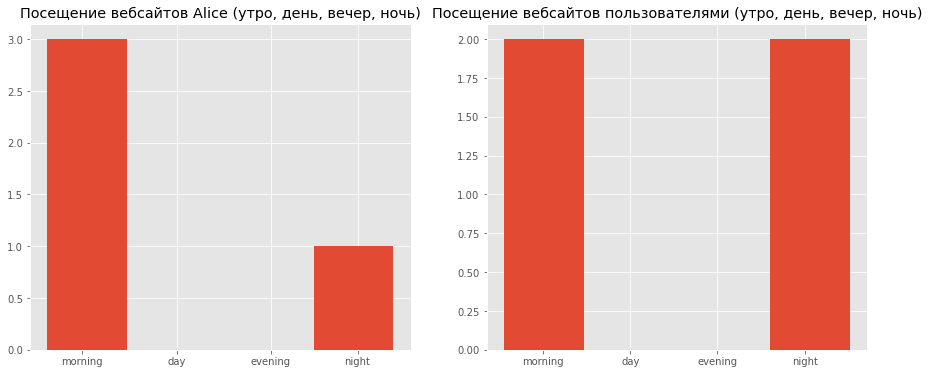

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

morning, day, evening, night = define_part_of_day(train_df[train_df['target'] == 1])
ax[0].hist([morning.sum(), day.sum(), evening.sum(), night.sum()], bins=4, rwidth=0.9)
morning, day, evening, night = define_part_of_day(train_df[train_df['target'] == 0])
ax[1].hist([morning.sum(), day.sum(), evening.sum(), night.sum()], bins=4, rwidth=0.9)

ax[0].set_xticks(ticks=[i for i in [250, 850, 1450, 2000]])
ax[1].set_xticks(ticks=[i for i in [15000, 45000, 75000, 105000]])
ax[0].set_xticklabels(labels=['morning', 'day', 'evening', 'night'])
ax[1].set_xticklabels(labels=['morning', 'day', 'evening', 'night'])
ax[0].set_title('Посещение вебсайтов Alice (утро, день, вечер, ночь)')
ax[1].set_title('Посещение вебсайтов пользователями (утро, день, вечер, ночь)')

plt.show()

In [55]:
tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.9215002888747204
K Fold: 2
roc_auc_score = 0.8951535072049541
K Fold: 3
roc_auc_score = 0.956887779362815
K Fold: 4
roc_auc_score = 0.9635859489862816
K Fold: 5
roc_auc_score = 0.978187245897732
Mean roc_auc_score = 0.9430629540653006


In [56]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(train_df)
X_train_tmp = hstack([X_train_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(test_df)
X_test_tmp = hstack([X_test_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

get_auc_lr_valid_with_params(X_train_tmp,
                 X_test_tmp,
                 y, 
                 C=logit_grid_searcher.best_params_['C'], solver=logit_grid_searcher.best_params_['solver'],
                 for_test=True, out_file='predictions.csv')

CPU times: user 39.1 s, sys: 795 ms, total: 39.9 s
Wall time: 24.7 s


'Done!'

### Среднее время сессии

In [57]:
%%time

tmp_time = train_df[times].copy()

col_nulls = 10-tmp_time.isnull().sum(axis=1)
tmp_time = tmp_time.fillna(method='ffill', axis=1)
tmp_time['num_notnull'] = col_nulls
tmp_time['time_of_session'] = tmp_time.apply(lambda x: (pd.to_datetime(x.time2)-pd.to_datetime(x.time1)).seconds+
                         (pd.to_datetime(x.time3)-pd.to_datetime(x.time2)).seconds+
                         (pd.to_datetime(x.time4)-pd.to_datetime(x.time3)).seconds+
                         (pd.to_datetime(x.time5)-pd.to_datetime(x.time4)).seconds+
                         (pd.to_datetime(x.time6)-pd.to_datetime(x.time5)).seconds+
                         (pd.to_datetime(x.time7)-pd.to_datetime(x.time6)).seconds+
                         (pd.to_datetime(x.time8)-pd.to_datetime(x.time7)).seconds+
                         (pd.to_datetime(x.time9)-pd.to_datetime(x.time8)).seconds+
                         (pd.to_datetime(x.time10)-pd.to_datetime(x.time9)).seconds, axis=1)

tmp_time_test = test_df[times].copy()

col_nulls = 10-tmp_time_test.isnull().sum(axis=1)
tmp_time_test = tmp_time_test.fillna(method='ffill', axis=1)
tmp_time_test['num_notnull'] = col_nulls
tmp_time_test['time_of_session'] = tmp_time_test.apply(lambda x: 
                         (pd.to_datetime(x.time2)-pd.to_datetime(x.time1)).seconds+
                         (pd.to_datetime(x.time3)-pd.to_datetime(x.time2)).seconds+
                         (pd.to_datetime(x.time4)-pd.to_datetime(x.time3)).seconds+
                         (pd.to_datetime(x.time5)-pd.to_datetime(x.time4)).seconds+
                         (pd.to_datetime(x.time6)-pd.to_datetime(x.time5)).seconds+
                         (pd.to_datetime(x.time7)-pd.to_datetime(x.time6)).seconds+
                         (pd.to_datetime(x.time8)-pd.to_datetime(x.time7)).seconds+
                         (pd.to_datetime(x.time9)-pd.to_datetime(x.time8)).seconds+
                         (pd.to_datetime(x.time10)-pd.to_datetime(x.time9)).seconds, axis=1)

tmp_time

CPU times: user 1min 30s, sys: 1.32 s, total: 1min 32s
Wall time: 1min 32s


,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,num_notnull,time_of_session
session_id,,,,,,,,,,,,
27554,2013-11-15 07:39:35,2013-11-15 07:39:35,2013-11-15 07:39:36,2013-11-15 07:39:36,2013-11-15 07:39:40,2013-11-15 07:39:41,2013-11-15 07:42:50,2013-11-15 07:42:50,2013-11-15 07:42:50,2013-11-15 07:44:25,10,290
81350,2013-11-15 07:44:25,2013-11-15 07:44:25,2013-11-15 07:57:45,2013-11-15 07:57:45,2013-11-15 07:57:45,2013-11-15 07:57:46,2013-11-15 07:57:47,2013-11-15 07:57:49,2013-11-15 07:57:49,2013-11-15 07:57:49,10,804
234665,2013-11-15 07:52:17,2013-11-15 07:52:18,2013-11-15 07:52:19,2013-11-15 07:52:19,2013-11-15 07:52:20,2013-11-15 07:52:20,2013-11-15 07:52:23,2013-11-15 07:52:26,2013-11-15 07:52:26,2013-11-15 07:52:28,10,11
97610,2013-11-15 07:52:28,2013-11-15 07:52:29,2013-11-15 07:52:37,2013-11-15 07:52:37,2013-11-15 07:55:10,2013-11-15 07:55:10,2013-11-15 07:55:56,2013-11-15 07:57:50,2013-11-15 08:01:18,2013-11-15 08:01:26,10,538
161358,2013-11-15 07:57:50,2013-11-15 07:57:51,2013-11-15 07:59:34,2013-11-15 07:59:34,2013-11-15 07:59:34,2013-11-15 07:59:34,2013-11-15 07:59:34,2013-11-15 07:59:34,2013-11-15 07:59:34,2013-11-15 07:59:34,5,104
...,...,...,...,...,...,...,...,...,...,...,...,...
129606,2014-05-03 18:06:13,2014-05-03 18:06:13,2014-05-03 18:06:13,2014-05-03 18:06:13,2014-05-03 18:06:13,2014-05-03 18:06:13,2014-05-03 18:06:13,2014-05-03 18:06:13,2014-05-03 18:06:13,2014-05-03 18:06:13,1,0
53628,2014-05-03 18:09:26,2014-05-03 18:09:26,2014-05-03 18:09:26,2014-05-03 18:09:26,2014-05-03 18:09:26,2014-05-03 18:09:26,2014-05-03 18:09:26,2014-05-03 18:09:26,2014-05-03 18:09:26,2014-05-03 18:09:26,1,0
84754,2014-05-03 18:11:21,2014-05-03 18:11:21,2014-05-03 18:11:21,2014-05-03 18:11:21,2014-05-03 18:11:21,2014-05-03 18:11:21,2014-05-03 18:11:21,2014-05-03 18:11:21,2014-05-03 18:11:21,2014-05-03 18:11:21,1,0


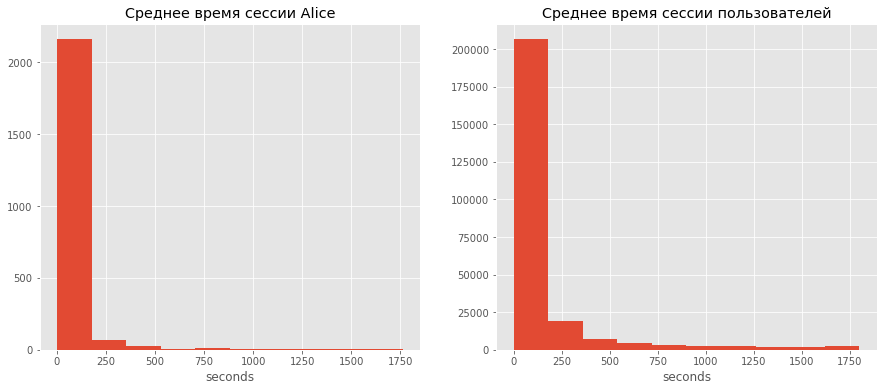

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].hist(tmp_time.loc[train_df[train_df.target==1].index, 'time_of_session'])
ax[1].hist(tmp_time.loc[train_df[train_df.target==0].index, 'time_of_session'])

ax[0].set_title('Среднее время сессии Alice')
ax[1].set_title('Среднее время сессии пользователей')

ax[0].set_xlabel('seconds')
ax[1].set_xlabel('seconds')

plt.show()

In [76]:
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.921738155235221
K Fold: 2
roc_auc_score = 0.8961885521885521
K Fold: 3
roc_auc_score = 0.9576472895863053
K Fold: 4
roc_auc_score = 0.963933104291057
K Fold: 5
roc_auc_score = 0.9782486700231122
Mean roc_auc_score = 0.9435511542648495


In [77]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

#mean time of session
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(train_df)
X_train_tmp = hstack([X_train_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf, time_of_session_test))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(test_df)
X_test_tmp = hstack([X_test_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

get_auc_lr_valid_with_params(X_train_tmp,
                 X_test_tmp,
                 y, 
                 C=logit_grid_searcher.best_params_['C'], solver=logit_grid_searcher.best_params_['solver'],
                 for_test=True, out_file='predictions.csv')

CPU times: user 45.7 s, sys: 1.49 s, total: 47.2 s
Wall time: 28.5 s


'Done!'

### Количество уникальных сайтов/доменов за сессию

In [78]:
train_df['unique_sites'] = train_df.apply(lambda x: len(set([x[f"site{i}"] for i in range(1, 11)])), axis=1)
test_df['unique_sites'] = test_df.apply(lambda x: len(set([x[f"site{i}"] for i in range(1, 11)])), axis=1)

train_df['unique_domens'] = train_df.apply(lambda x: len(set([x[f"site{i}_domen"] for i in range(1, 11)])), axis=1)
test_df['unique_domens'] = test_df.apply(lambda x: len(set([x[f"site{i}_domen"] for i in range(1, 11)])), axis=1)

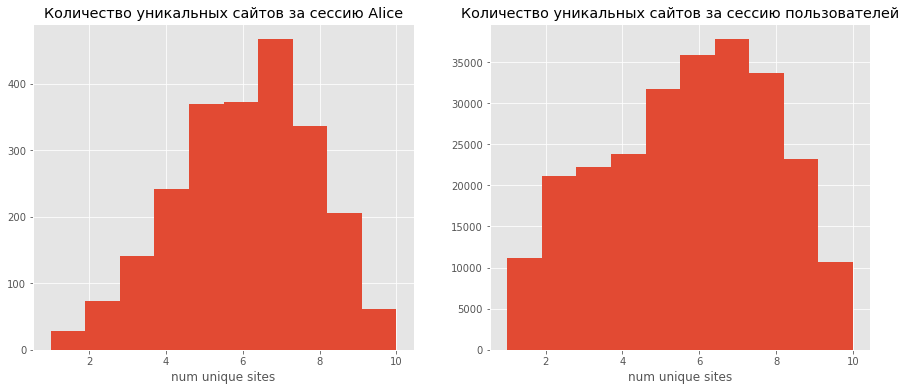

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].hist(train_df[train_df.target==1].unique_sites)
ax[1].hist(train_df[train_df.target==0].unique_sites)

ax[0].set_title('Количество уникальных сайтов за сессию Alice')
ax[1].set_title('Количество уникальных сайтов за сессию пользователей')

ax[0].set_xlabel('num unique sites')
ax[1].set_xlabel('num unique sites')

plt.show()

In [82]:
#mean time of session
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

#number unique sites for session
st = StandardScaler()
unique_sites_train = st.fit_transform(train_df['unique_sites'].values.reshape(-1, 1))
unique_sites_test = st.transform(test_df['unique_sites'].values.reshape(-1, 1))

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, unique_sites_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.9214803371888776
K Fold: 2
roc_auc_score = 0.8959812920198772
K Fold: 3
roc_auc_score = 0.9574062054208274
K Fold: 4
roc_auc_score = 0.9644896953766899
K Fold: 5
roc_auc_score = 0.9786457387013019
Mean roc_auc_score = 0.9436006537415148


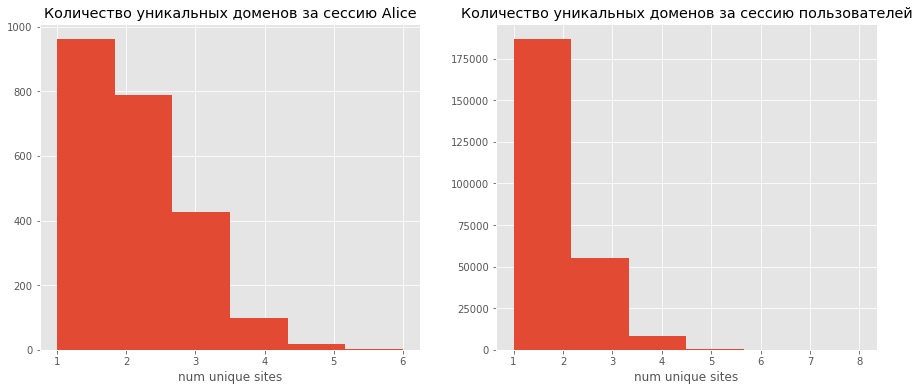

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].hist(train_df[train_df.target==1].unique_domens, bins=6)
ax[1].hist(train_df[train_df.target==0].unique_domens, bins=6)

ax[0].set_title('Количество уникальных доменов за сессию Alice')
ax[1].set_title('Количество уникальных доменов за сессию пользователей')

ax[0].set_xlabel('num unique sites')
ax[1].set_xlabel('num unique sites')

plt.show()

In [83]:
#mean time of session
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

#number unique domens for session
st = StandardScaler()
unique_domens_train = st.fit_transform(train_df['unique_domens'].values.reshape(-1, 1))
unique_domens_test = st.transform(test_df['unique_domens'].values.reshape(-1, 1))

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, unique_domens_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.9218005586389162
K Fold: 2
roc_auc_score = 0.8963165632747626
K Fold: 3
roc_auc_score = 0.9575392296718974
K Fold: 4
roc_auc_score = 0.9639120756258869
K Fold: 5
roc_auc_score = 0.9782431215334151
Mean roc_auc_score = 0.9435623097489756


In [89]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

#mean time of session
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

#number unique sites for session
st = StandardScaler()
unique_sites_train = st.fit_transform(train_df['unique_sites'].values.reshape(-1, 1))
unique_sites_test = st.transform(test_df['unique_sites'].values.reshape(-1, 1))

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, unique_sites_train))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(train_df)
X_train_tmp = hstack([X_train_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf, time_of_session_test, unique_sites_test))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(test_df)
X_test_tmp = hstack([X_test_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

get_auc_lr_valid_with_params(X_train_tmp,
                 X_test_tmp,
                 y, 
                 C=logit_grid_searcher.best_params_['C'], solver=logit_grid_searcher.best_params_['solver'],
                 for_test=True, out_file='predictions.csv')

CPU times: user 43.8 s, sys: 1.26 s, total: 45.1 s
Wall time: 27.2 s


'Done!'

### Топ-10 сайтов 

In [90]:
from collections import defaultdict

popularity_site_dict = defaultdict(int) 

for row in pd.concat([train_df[sites], test_df[sites]]).values : 
    for site_id in np.unique(row): 
        popularity_site_dict[site_id]  +=  1 
popularity_site_dict.pop(0)

30500

In [91]:
%%time

top_10 = sorted(list(popularity_site_dict.items()), key=lambda x: x[1], reverse = True)[:10]
top_10 = set([element[0] for element in top_10])

train_df['set_unique_sites'] = train_df.apply(lambda x: set([x[f"site{i}"] for i in range(1, 11)]), axis=1)
test_df['set_unique_sites'] = train_df.apply(lambda x: set([x[f"site{i}"] for i in range(1, 11)]), axis=1)

train_df['have_top_10'] = train_df['set_unique_sites'].apply(lambda x: 1 if len(top_10&x) else 0)
test_df['have_top_10'] = test_df['set_unique_sites'].apply(lambda x: 1 if len(top_10&x) else 0)

CPU times: user 37.2 s, sys: 819 ms, total: 38 s
Wall time: 38.3 s


In [92]:
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

have_top_10_train = train_df['have_top_10'].values.reshape(-1, 1)
have_top_10_test = test_df['have_top_10'].values.reshape(-1, 1)

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, have_top_10_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.9212377677830123
K Fold: 2
roc_auc_score = 0.8959812054088582
K Fold: 3
roc_auc_score = 0.9576495482643842
K Fold: 4
roc_auc_score = 0.9641425400719145
K Fold: 5
roc_auc_score = 0.9780299344926551
Mean roc_auc_score = 0.9434081992041647


In [93]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

#mean time of session
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

#number unique sites for session
st = StandardScaler()
unique_sites_train = st.fit_transform(train_df['unique_sites'].values.reshape(-1, 1))
unique_sites_test = st.transform(test_df['unique_sites'].values.reshape(-1, 1))

# has session any of top-10 popular site or not
have_top_10_train = train_df['have_top_10'].values.reshape(-1, 1)
have_top_10_test = test_df['have_top_10'].values.reshape(-1, 1)

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, have_top_10_train))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(train_df)
X_train_tmp = hstack([X_train_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf, time_of_session_test, have_top_10_test))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(test_df)
X_test_tmp = hstack([X_test_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

get_auc_lr_valid_with_params(X_train_tmp,
                 X_test_tmp,
                 y, 
                 C=logit_grid_searcher.best_params_['C'], solver=logit_grid_searcher.best_params_['solver'],
                 for_test=True, out_file='predictions.csv')

CPU times: user 51.9 s, sys: 1.71 s, total: 53.6 s
Wall time: 33.1 s


'Done!'

### Количество ненулевых сайтов в каждой сессии

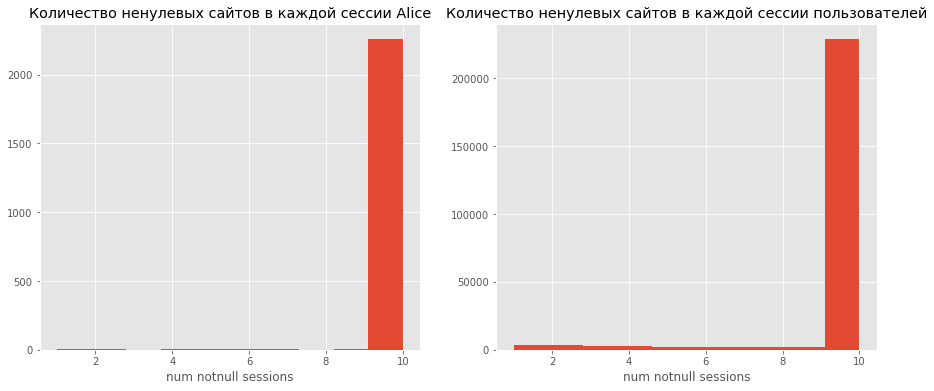

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].hist(tmp_time.loc[train_df[train_df.target==1].index, 'num_notnull'], bins=10)
ax[1].hist(tmp_time.loc[train_df[train_df.target==0].index, 'num_notnull'], bins=10)

ax[0].set_title('Количество ненулевых сайтов в каждой сессии Alice')
ax[1].set_title('Количество ненулевых сайтов в каждой сессии пользователей')

ax[0].set_xlabel('num notnull sessions')
ax[1].set_xlabel('num notnull sessions')

plt.show()

In [98]:
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, num_notnull_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.921600337359596
K Fold: 2
roc_auc_score = 0.8963489557959011
K Fold: 3
roc_auc_score = 0.9572452448882548
K Fold: 4
roc_auc_score = 0.9638317898840085
K Fold: 5
roc_auc_score = 0.9783869133790888
Mean roc_auc_score = 0.9434826482613697


In [99]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

#mean time of session
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

#number unique sites for session
st = StandardScaler()
unique_sites_train = st.fit_transform(train_df['unique_sites'].values.reshape(-1, 1))
unique_sites_test = st.transform(test_df['unique_sites'].values.reshape(-1, 1))

# has session any of top-10 popular site or not
have_top_10_train = train_df['have_top_10'].values.reshape(-1, 1)
have_top_10_test = test_df['have_top_10'].values.reshape(-1, 1)

# num notnull sites in session
st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, num_notnull_train))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(train_df)
X_train_tmp = hstack([X_train_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf, time_of_session_test, num_notnull_test))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(test_df)
X_test_tmp = hstack([X_test_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

get_auc_lr_valid_with_params(X_train_tmp,
                 X_test_tmp,
                 y, 
                 C=logit_grid_searcher.best_params_['C'], solver=logit_grid_searcher.best_params_['solver'],
                 for_test=True, out_file='predictions.csv')

CPU times: user 41.1 s, sys: 1.12 s, total: 42.2 s
Wall time: 27 s


'Done!'

In [43]:
gs_params1 = {'C': 3.359818286283781, 'solver': 'liblinear'}

In [44]:
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, num_notnull_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=gs_params1['C'], 
                                                 solver=gs_params1['solver'])
#                                                  C=logit_grid_searcher_new.best_params_['C'], 
#                                                  solver=logit_grid_searcher_new.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.921600337359596
K Fold: 2
roc_auc_score = 0.8963489557959011
K Fold: 3
roc_auc_score = 0.9572452448882548
K Fold: 4
roc_auc_score = 0.9638317898840085
K Fold: 5
roc_auc_score = 0.9783869133790888
Mean roc_auc_score = 0.9434826482613697


### Время, проведенное на сайтах, в течение сессии

In [101]:
%%time

for i in range(1, 10):
    tmp_time[f"time_diff{i}"] = tmp_time.apply(lambda x: (x[i]-x[i-1]).seconds, axis=1)

CPU times: user 2min 17s, sys: 3.59 s, total: 2min 21s
Wall time: 2min 22s


In [102]:
%%time

for i in range(1, 10):
    tmp_time_test[f"time_diff{i}"] = tmp_time_test.apply(lambda x: (x[i]-x[i-1]).seconds, axis=1)

CPU times: user 47.9 s, sys: 601 ms, total: 48.5 s
Wall time: 48.8 s


In [105]:
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

time_diffs = [f"time_diff{i}" for i in range (1, 10)]
st = StandardScaler()
time_diffs_train = st.fit_transform(tmp_time[time_diffs].values)
time_diffs_test = st.transform(tmp_time_test[time_diffs].values)

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, time_diffs_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.9197736289597207
K Fold: 2
roc_auc_score = 0.896232204142172
K Fold: 3
roc_auc_score = 0.9580499286733237
K Fold: 4
roc_auc_score = 0.96424458379683
K Fold: 5
roc_auc_score = 0.9776295054615503
Mean roc_auc_score = 0.9431859702067193


In [107]:
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

time_diffs = [f"time_diff{i}" for i in range (1, 10)]
st = StandardScaler()
time_diffs_train = st.fit_transform(tmp_time[time_diffs].values)
time_diffs_test = st.transform(tmp_time_test[time_diffs].values)

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, time_diffs_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    # закодируем день недели с помощью get_dummies
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
        coo_matrix(pd.get_dummies(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).values)))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
        coo_matrix(pd.get_dummies(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).values)))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.9464854349171243
K Fold: 2
roc_auc_score = 0.8408945186051295
K Fold: 3
roc_auc_score = 0.960860912981455
K Fold: 4
roc_auc_score = 0.9648560560519678
K Fold: 5
roc_auc_score = 0.9783376021537519
Mean roc_auc_score = 0.9382869049418856


In [108]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

#mean time of session
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

# #number unique sites for session
# st = StandardScaler()
# unique_sites_train = st.fit_transform(train_df['unique_sites'].values.reshape(-1, 1))
# unique_sites_test = st.transform(test_df['unique_sites'].values.reshape(-1, 1))

# # has session any of top-10 popular site or not
# have_top_10_train = train_df['have_top_10'].values.reshape(-1, 1)
# have_top_10_test = test_df['have_top_10'].values.reshape(-1, 1)

# num notnull sites in session
st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

# time_diffs within session
time_diffs = [f"time_diff{i}" for i in range (1, 10)]
st = StandardScaler()
time_diffs_train = st.fit_transform(tmp_time[time_diffs].values)
time_diffs_test = st.transform(tmp_time_test[time_diffs].values)

X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, time_diffs_train))
X_train_tmp = hstack((X_train_tmp, coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(train_df)
X_train_tmp = hstack([X_train_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf, time_of_session_test, time_diffs_test))
X_test_tmp = hstack((X_test_tmp, coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
morning, day, evening, night = define_part_of_day(test_df)
X_test_tmp = hstack([X_test_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

get_auc_lr_valid_with_params(X_train_tmp,
                 X_test_tmp,
                 y, 
                 C=logit_grid_searcher.best_params_['C'], solver=logit_grid_searcher.best_params_['solver'],
                 for_test=True, out_file='predictions.csv')

CPU times: user 1min 27s, sys: 2.41 s, total: 1min 29s
Wall time: 41.1 s


'Done!'

### Любимый день Алисы

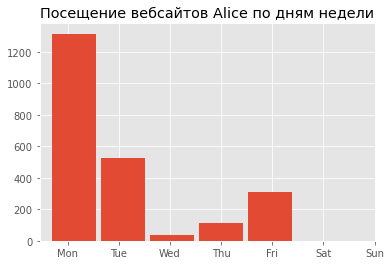

In [109]:
plt.hist(train_df[train_df['target'] == 1].apply(lambda x: pd.to_datetime(x.time1).dayofweek, axis=1), 
           bins=5, rwidth=0.9)

plt.xticks(ticks=[i - 0.7 for i in np.linspace(1,6,7)], labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Посещение вебсайтов Alice по дням недели')

plt.show()

In [110]:
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

time_diffs = [f"time_diff{i}" for i in range (1, 10)]
st = StandardScaler()
time_diffs_train = st.fit_transform(tmp_time[time_diffs].values)
time_diffs_test = st.transform(tmp_time_test[time_diffs].values)

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, time_diffs_train))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
        coo_matrix(pd.get_dummies(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).values)))
    X_train = hstack((X_train, 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: 
                                                            pd.to_datetime(x).dayofweek in [0]).astype(int)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
        coo_matrix(pd.get_dummies(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).values)))
    X_test = hstack((X_test, 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: 
                                                            pd.to_datetime(x).dayofweek in [0]).astype(int)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.9465076034569496
K Fold: 2
roc_auc_score = 0.840913832862386
K Fold: 3
roc_auc_score = 0.9608796956728484
K Fold: 4
roc_auc_score = 0.9648621337008609
K Fold: 5
roc_auc_score = 0.9783401028815026
Mean roc_auc_score = 0.9383006737149095


### Абсолютно уникальные сайты

In [116]:
from collections import defaultdict

unique_sites_dict = defaultdict(int)

def get_unique_sites_dict(set_sites):
    for site_id in set_sites:
        unique_sites_dict[site_id] += 1

train_df['set_unique_sites'].apply(lambda x: get_unique_sites_dict(x))

session_id
27554     None
81350     None
234665    None
97610     None
161358    None
          ... 
129606    None
53628     None
84754     None
153398    None
11690     None
Name: set_unique_sites, Length: 253561, dtype: object

In [117]:
abs_unique_sites = []

for k, v in unique_sites_dict.items():
    if v == 1:
        abs_unique_sites.append(k)
        
len(abs_unique_sites), len(unique_sites_dict)

(18628, 41602)

In [118]:
abs_unique_sites = set(abs_unique_sites)

In [119]:
%%time

train_df['abs_unique_sites'] = train_df['site1'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site2'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site3'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site4'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site5'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site6'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site7'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site8'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site9'].apply(lambda x: int(x in abs_unique_sites)) +\
                               train_df['site10'].apply(lambda x: int(x in abs_unique_sites))


CPU times: user 958 ms, sys: 20.9 ms, total: 979 ms
Wall time: 976 ms


In [120]:
train_df['abs_unique_sites'] = (train_df['abs_unique_sites'] > 0).astype(int)

In [122]:
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

time_diffs = [f"time_diff{i}" for i in range (1, 10)]
st = StandardScaler()
time_diffs_train = st.fit_transform(tmp_time[time_diffs].values)
time_diffs_test = st.transform(tmp_time_test[time_diffs].values)

tscv = TimeSeriesSplit(n_splits=5)

X_for_tscv = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, time_diffs_train,
                    train_df['abs_unique_sites'].values.reshape(-1, 1)))
i = 1

scores = []

for train_index, test_index in tscv.split(X_for_tscv):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
                     coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
#     X_train = hstack((X_for_tscv.tocsr()[train_index,:], 
#         coo_matrix(pd.get_dummies(train_df.iloc[train_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).values)))
    X_train = hstack((X_train, 
                      coo_matrix(train_df.iloc[train_index].time1.apply(lambda x: 
                                                             pd.to_datetime(x).dayofweek in [0]).astype(int)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[train_index])
    X_train = hstack([X_train, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
                     coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
#     X_test = hstack((X_for_tscv.tocsr()[test_index,:], 
#         coo_matrix(pd.get_dummies(train_df.iloc[test_index].time1.apply(lambda x: pd.to_datetime(x).dayofweek)).values)))
    X_test = hstack((X_test, 
                      coo_matrix(train_df.iloc[test_index].time1.apply(lambda x: 
                                                             pd.to_datetime(x).dayofweek in [0]).astype(int)).T))
    morning, day, evening, night = define_part_of_day(train_df.iloc[test_index])
    X_test = hstack([X_test, morning.values.reshape(-1, 1), 
                               day.values.reshape(-1, 1), 
                               evening.values.reshape(-1, 1), 
                               night.values.reshape(-1, 1)])
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    roc_auc_score = get_auc_lr_valid_with_params(X_train, X_test, y_train, y_test,
                                                 C=logit_grid_searcher.best_params_['C'], 
                                                 solver=logit_grid_searcher.best_params_['solver'])
    print(f"K Fold: {i}")
    print(f"roc_auc_score = {roc_auc_score}")
    scores.append(roc_auc_score)
    i += 1
print(f"Mean roc_auc_score = {np.mean(scores)}")

K Fold: 1
roc_auc_score = 0.9308163380398179
K Fold: 2
roc_auc_score = 0.9003829506208928
K Fold: 3
roc_auc_score = 0.950490727532097
K Fold: 4
roc_auc_score = 0.9568420682214873
K Fold: 5
roc_auc_score = 0.9708861367859005
Mean roc_auc_score = 0.9418836442400391


In [123]:
unique_sites_dict = defaultdict(int)
test_df['set_unique_sites'].apply(lambda x: get_unique_sites_dict(x))

abs_unique_sites = []

for k, v in unique_sites_dict.items():
    if v == 1:
        abs_unique_sites.append(k)
        
abs_unique_sites = set(abs_unique_sites)
        
len(abs_unique_sites), len(unique_sites_dict)

(12525, 24070)

In [124]:
%%time

test_df['abs_unique_sites'] = test_df['site1'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site2'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site3'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site4'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site5'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site6'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site7'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site8'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site9'].apply(lambda x: int(x in abs_unique_sites)) +\
                               test_df['site10'].apply(lambda x: int(x in abs_unique_sites))
test_df['abs_unique_sites'] = (test_df['abs_unique_sites'] > 0 ).astype(int)

CPU times: user 411 ms, sys: 17.3 ms, total: 428 ms
Wall time: 426 ms


In [126]:
%%time

n_ngram = 3

# domens
tfidf_domen = TfidfVectorizer(ngram_range=(1, n_ngram))
X_domens_tfidf = tfidf_domen.fit_transform(X_domens)
test_domens_tfidf = tfidf_domen.transform(test_domens)

# sites
tfidf = TfidfVectorizer(ngram_range=(1, n_ngram), max_features=50000)
X_sites_tfidf = tfidf.fit_transform(X_sites)
test_sites_tfidf = tfidf.transform(test_sites)

#mean time of session
st = StandardScaler()
time_of_session_train = st.fit_transform(tmp_time['time_of_session'].values.reshape(-1, 1))
time_of_session_test = st.transform(tmp_time_test['time_of_session'].values.reshape(-1, 1))

# #number unique sites for session
# st = StandardScaler()
# unique_sites_train = st.fit_transform(train_df['unique_sites'].values.reshape(-1, 1))
# unique_sites_test = st.transform(test_df['unique_sites'].values.reshape(-1, 1))

# # has session any of top-10 popular site or not
# have_top_10_train = train_df['have_top_10'].values.reshape(-1, 1)
# have_top_10_test = test_df['have_top_10'].values.reshape(-1, 1)

# num notnull sites in session
st = StandardScaler()
num_notnull_train = st.fit_transform(tmp_time['num_notnull'].values.reshape(-1, 1))
num_notnull_test = st.transform(tmp_time_test['num_notnull'].values.reshape(-1, 1))

# time_diffs within session
time_diffs = [f"time_diff{i}" for i in range (1, 10)]
st = StandardScaler()
time_diffs_train = st.fit_transform(tmp_time[time_diffs].values)
time_diffs_test = st.transform(tmp_time_test[time_diffs].values)

# month
ohe = OneHotEncoder()
month_train = ohe.fit_transform(train_df.time1.apply(lambda x: pd.to_datetime(x).month).values.reshape(-1, 1))
month_test = ohe.transform(test_df.time1.apply(lambda x: pd.to_datetime(x).month).values.reshape(-1, 1))


X_train_tmp = hstack((X_sites_tfidf, X_domens_tfidf, time_of_session_train, 
                      time_diffs_train, num_notnull_train, month_train))
# X_train_tmp = hstack((X_train_tmp, 
#             coo_matrix(pd.get_dummies(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).values)))
X_train_tmp = hstack((X_train_tmp, 
                     coo_matrix(train_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
X_train_tmp = hstack((X_train_tmp, 
                     coo_matrix(train_df.time1.apply(lambda x: 
                                                            pd.to_datetime(x).dayofweek in [0]).astype(int)).T))
morning, day, evening, night = define_part_of_day(train_df)
X_train_tmp = hstack([X_train_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

X_test_tmp = hstack((test_sites_tfidf, test_domens_tfidf, time_of_session_test,
                     time_diffs_test, num_notnull_test, month_test))
# X_test_tmp = hstack((X_test_tmp, 
#             coo_matrix(pd.get_dummies(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).values)))
X_test_tmp = hstack((X_test_tmp, 
                     coo_matrix(test_df.time1.apply(lambda x: pd.to_datetime(x).dayofweek)).T))
X_test_tmp = hstack((X_test_tmp, 
                     coo_matrix(test_df.time1.apply(lambda x: 
                                                            pd.to_datetime(x).dayofweek in [0]).astype(int)).T))

morning, day, evening, night = define_part_of_day(test_df)
X_test_tmp = hstack([X_test_tmp, morning.values.reshape(-1, 1), 
                                   day.values.reshape(-1, 1), 
                                   evening.values.reshape(-1, 1), 
                                   night.values.reshape(-1, 1)])

get_auc_lr_valid_with_params(X_train_tmp,
                 X_test_tmp,
                 y, 
                 C=logit_grid_searcher.best_params_['C'], 
                 solver=logit_grid_searcher.best_params_['solver'],
                 for_test=True, out_file='predictions.csv')

CPU times: user 1min 48s, sys: 2.94 s, total: 1min 51s
Wall time: 52.4 s


'Done!'